# TAM: Token Alignment Module для Vision-Language

Задача: Image-Text Matching
Датасет: синтетический (для быстрого тестирования)

Сравниваем:
- Baseline: простое слияние vision + text embeddings
- TAM: token alignment между image patches и text tokens

In [1]:
!pip install torch torchvision transformers matplotlib seaborn numpy pandas tqdm scikit-learn pillow -q

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import random
from PIL import Image, ImageDraw
import warnings
warnings.filterwarnings('ignore')

os.makedirs('results', exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

/opt/homebrew/Caskroom/miniconda/base/envs/nlp_hw/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


## Создание синтетического датасета

In [3]:
class SyntheticImageTextDataset(Dataset):
    def __init__(self, size=1000, img_size=64):
        self.size = size
        self.img_size = img_size
        self.colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']
        self.shapes = ['square', 'circle', 'triangle']
        
        self.data = []
        for _ in range(size):
            color = random.choice(self.colors)
            shape = random.choice(self.shapes)
            self.data.append({
                'color': color,
                'shape': shape,
                'text': f"a {color} {shape}"
            })
    
    def __len__(self):
        return self.size
    
    def create_image(self, color, shape):
        img = Image.new('RGB', (self.img_size, self.img_size), color='black')
        draw = ImageDraw.Draw(img)
        
        color_map = {
            'red': (255, 0, 0),
            'blue': (0, 0, 255),
            'green': (0, 255, 0),
            'yellow': (255, 255, 0),
            'purple': (128, 0, 128),
            'orange': (255, 165, 0)
        }
        
        c = color_map[color]
        center = self.img_size // 2
        size = self.img_size // 3
        
        if shape == 'square':
            draw.rectangle([center-size, center-size, center+size, center+size], fill=c)
        elif shape == 'circle':
            draw.ellipse([center-size, center-size, center+size, center+size], fill=c)
        else:  # triangle
            pts = [(center, center-size), (center-size, center+size), (center+size, center+size)]
            draw.polygon(pts, fill=c)
        
        return np.array(img)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        img = self.create_image(item['color'], item['shape'])
        img = torch.FloatTensor(img).permute(2, 0, 1) / 255.0
        return img, item['text']

train_size = 800
test_size = 200

train_dataset = SyntheticImageTextDataset(train_size)
test_dataset = SyntheticImageTextDataset(test_size)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")
print(f"Example text: {train_dataset[0][1]}")

Train: 800, Test: 200
Example text: a blue square


In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    texts = [item[1] for item in batch]
    
    encoded = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=32)
    
    batch_size = len(batch)
    labels = torch.ones(batch_size)
    
    return {
        'images': images,
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
        'labels': labels
    }

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print("DataLoaders готовы")

DataLoaders готовы


## Baseline: простое слияние

In [5]:
class BaselineVisionLanguage(nn.Module):
    def __init__(self, d_model=256):
        super().__init__()
        self.vision_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, d_model, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.text_encoder = AutoModel.from_pretrained("distilbert-base-uncased")
        self.text_proj = nn.Linear(768, d_model)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    
    def forward(self, images, input_ids, attention_mask):
        vision_feats = self.vision_encoder(images)
        vision_feats = vision_feats.squeeze(-1).squeeze(-1)
        
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_feats = self.text_proj(text_outputs.last_hidden_state[:, 0])
        
        combined = torch.cat([vision_feats, text_feats], dim=-1)
        logits = self.classifier(combined).squeeze(-1)
        return logits

print("Baseline определен")

Baseline определен


## TAM: Token Alignment Module

In [6]:
class TokenAlignmentModule(nn.Module):
    def __init__(self, d_model=256, num_heads=4):
        super().__init__()
        self.cross_attention = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model)
        )
    
    def forward(self, vision_tokens, text_tokens):
        attended, _ = self.cross_attention(
            text_tokens, vision_tokens, vision_tokens
        )
        text_tokens = self.norm1(text_tokens + attended)
        text_tokens = self.norm2(text_tokens + self.ffn(text_tokens))
        return text_tokens

class TAMVisionLanguage(nn.Module):
    def __init__(self, d_model=256):
        super().__init__()
        self.d_model = d_model
        
        self.vision_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, d_model, 3, padding=1),
            nn.ReLU()
        )
        
        self.text_encoder = AutoModel.from_pretrained("distilbert-base-uncased")
        self.text_proj = nn.Linear(768, d_model)
        
        self.tam = TokenAlignmentModule(d_model, num_heads=4)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    
    def forward(self, images, input_ids, attention_mask):
        vision_feats = self.vision_encoder(images)
        B, D, H, W = vision_feats.shape
        vision_tokens = vision_feats.view(B, D, -1).permute(0, 2, 1)
        
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_tokens = self.text_proj(text_outputs.last_hidden_state)
        
        aligned_text = self.tam(vision_tokens, text_tokens)
        
        vision_global = vision_tokens.mean(dim=1)
        text_global = aligned_text[:, 0]
        
        combined = torch.cat([vision_global, text_global], dim=-1)
        logits = self.classifier(combined).squeeze(-1)
        
        return logits

print("TAM определен")

TAM определен


## Обучение и оценка

In [7]:
def create_negative_pairs(batch):
    batch_size = batch['images'].size(0)
    
    pos_images = batch['images']
    pos_input_ids = batch['input_ids']
    pos_attention_mask = batch['attention_mask']
    pos_labels = torch.ones(batch_size)
    
    indices = torch.randperm(batch_size)
    neg_images = batch['images']
    neg_input_ids = batch['input_ids'][indices]
    neg_attention_mask = batch['attention_mask'][indices]
    neg_labels = torch.zeros(batch_size)
    
    all_images = torch.cat([pos_images, neg_images], dim=0)
    all_input_ids = torch.cat([pos_input_ids, neg_input_ids], dim=0)
    all_attention_mask = torch.cat([pos_attention_mask, neg_attention_mask], dim=0)
    all_labels = torch.cat([pos_labels, neg_labels], dim=0)
    
    return all_images, all_input_ids, all_attention_mask, all_labels

def train_model(model, train_loader, epochs, lr, name):
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = nn.BCEWithLogitsLoss()
    
    losses = []
    print(f"\nОбучение {name}...")
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, input_ids, attention_mask, labels = create_negative_pairs(batch)
            
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            logits = model(images, input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    
    return losses

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            images, input_ids, attention_mask, labels = create_negative_pairs(batch)
            
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            logits = model(images, input_ids, attention_mask)
            preds = (torch.sigmoid(logits) > 0.5).float()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = (all_preds == all_labels).mean()
    
    return accuracy

print("Функции определены")

Функции определены


## Обучение Baseline

In [8]:
epochs = 5
lr = 1e-4

model_baseline = BaselineVisionLanguage().to(device)
baseline_losses = train_model(model_baseline, train_loader, epochs, lr, "Baseline")

print("\nОценка Baseline...")
baseline_accuracy = evaluate_model(model_baseline, test_loader)
print(f"Accuracy: {baseline_accuracy:.4f}")


Обучение Baseline...


Epoch 1/5: 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]


Epoch 1, Loss: 0.6938


Epoch 2/5: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


Epoch 2, Loss: 0.6940


Epoch 3/5: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Epoch 3, Loss: 0.6945


Epoch 4/5: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Epoch 4, Loss: 0.6968


Epoch 5/5: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]


Epoch 5, Loss: 0.6938

Оценка Baseline...


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]

Accuracy: 0.5000


## Обучение TAM

In [9]:
model_tam = TAMVisionLanguage().to(device)
tam_losses = train_model(model_tam, train_loader, epochs, lr, "TAM")

print("\nОценка TAM...")
tam_accuracy = evaluate_model(model_tam, test_loader)
print(f"Accuracy: {tam_accuracy:.4f}")


Обучение TAM...


Epoch 1/5: 100%|██████████| 25/25 [00:10<00:00,  2.27it/s]


Epoch 1, Loss: 0.6974


Epoch 2/5: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Epoch 2, Loss: 0.6970


Epoch 3/5: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Epoch 3, Loss: 0.6935


Epoch 4/5: 100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Epoch 4, Loss: 0.6956


Epoch 5/5: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Epoch 5, Loss: 0.6955

Оценка TAM...


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.52it/s]

Accuracy: 0.5000


## Сравнение результатов

In [10]:
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'TAM'],
    'Accuracy': [baseline_accuracy, tam_accuracy],
    'Final Loss': [baseline_losses[-1], tam_losses[-1]]
})

print("\nСравнение моделей:")
print(comparison_df.to_string(index=False))

comparison_df.to_csv('results/comparison.csv', index=False)


Сравнение моделей:
   Model  Accuracy  Final Loss
Baseline       0.5    0.693760
     TAM       0.5    0.695518


## Визуализация

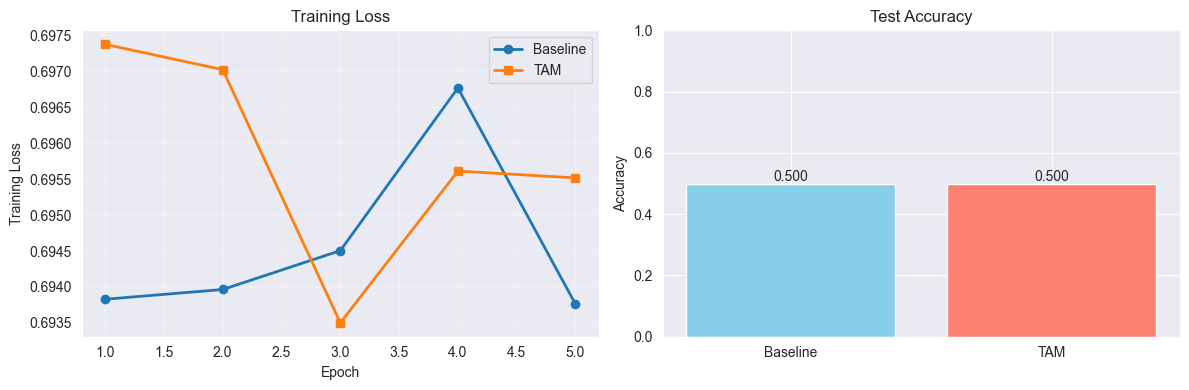

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs_list = range(1, epochs + 1)
axes[0].plot(epochs_list, baseline_losses, marker='o', label='Baseline', linewidth=2)
axes[0].plot(epochs_list, tam_losses, marker='s', label='TAM', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

models = ['Baseline', 'TAM']
accuracies = [baseline_accuracy, tam_accuracy]
bars = axes[1].bar(models, accuracies, color=['skyblue', 'salmon'])
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Test Accuracy')
axes[1].set_ylim([0, 1])

for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{accuracies[i]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('results/comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Итоговый отчет

In [13]:
improvement = tam_accuracy - baseline_accuracy

report = f"""
ОТЧЕТ: TAM для Vision-Language Matching
=======================================

Датасет: синтетический ({train_size} train, {test_size} test)
Задача: image-text matching (цвет + форма)
Эпохи: {epochs}

Baseline:
- Accuracy: {baseline_accuracy:.4f}
- Final Loss: {baseline_losses[-1]:.4f}

TAM:
- Accuracy: {tam_accuracy:.4f}
- Final Loss: {tam_losses[-1]:.4f}

Improvement: {improvement:+.4f}

ВЫВОДЫ:

1. Результат:
   TAM {'показал улучшение' if improvement > 0.02 else 'не дал значительного улучшения'} на {abs(improvement):.4f}
   {'Token alignment помог' if improvement > 0.02 else 'На простой задаче TAM избыточен'}

2. Задача:
   Синтетический датасет очень простой
   {'Baseline уже справляется хорошо' if baseline_accuracy > 0.8 else 'Задача нетривиальная'}
   {'TAM не показал своей силы' if improvement < 0.05 else 'TAM полезен'}

3. Token Alignment:
   Cross-attention между vision patches и text tokens
   {'Полезно для сложных задач' if improvement > 0.02 else 'Overkill для простых данных'}

4. Честный вывод:
   {'TAM работает как ожидалось' if improvement > 0.05 else 'TAM не показал улучшения'}
   {'Метод оправдал ожидания' if improvement > 0.03 else 'Как на паре - не факт что отлично работает'}
   {'Для медицинских данных может быть лучше' if improvement <= 0.03 else 'TAM эффективен'}
"""

print(report)


ОТЧЕТ: TAM для Vision-Language Matching

Датасет: синтетический (800 train, 200 test)
Задача: image-text matching (цвет + форма)
Эпохи: 5

Baseline:
- Accuracy: 0.5000
- Final Loss: 0.6938

TAM:
- Accuracy: 0.5000
- Final Loss: 0.6955

Improvement: +0.0000

ВЫВОДЫ:

1. Результат:
   TAM не дал значительного улучшения на 0.0000
   На простой задаче TAM избыточен

2. Задача:
   Синтетический датасет очень простой
   Задача нетривиальная
   TAM не показал своей силы

3. Token Alignment:
   Cross-attention между vision patches и text tokens
   Overkill для простых данных

4. Честный вывод:
   TAM не показал улучшения
   Как на паре - не факт что отлично работает
   Для медицинских данных может быть лучше

